# Analysis of extractive structures results

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
# Add the top level of the directory to the python path, so we can import the scripts
import sys
from pathlib import Path
import os
from shared_ml.utils import get_root_of_git_repo
from transformers import AutoTokenizer
import torch
from transformers.generation.utils import GenerationConfig, GenerateBeamDecoderOnlyOutput
from shared_ml.utils import default_function_args_to_cache_id, hash_str
from transformers import PreTrainedModel, PreTrainedTokenizer, PreTrainedTokenizerFast
from typing import Any
from termcolor import colored
repo_root = get_root_of_git_repo()
import matplotlib.pyplot as plt
from typing import Any, cast
import seaborn as sns
import json
from oocr_influence.cli.train_extractive import TrainingArgs
from oocr_influence.cli.run_influence import InfluenceArgs
from dataclasses import dataclass
from datasets import DatasetDict
from shared_ml.logging import LogState
import re
from collections import defaultdict
from typing import TypeVar
from numpy.typing import NDArray
from shared_ml.utils import cache_function_outputs
from itertools import chain, groupby
import hashlib
import pandas as pd
import numpy.typing as npt
import numpy as np
import matplotlib.pyplot as plt
if repo_root not in sys.path:
    sys.path.append(repo_root)
# Also chang the CWD to the repo, so we can import items from the various scripts.
os.chdir(repo_root)
from shared_ml.logging import load_experiment_checkpoint

# from examples.mnist.pipeline import get_mnist_dataset, construct_mnist_classifier, add_box_to_mnist_dataset

import logging
from typing import Literal
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, Conv1D
from torch import nn
from kronfluence.analyzer import Analyzer, prepare_model
from datasets import Dataset
from kronfluence.arguments import FactorArguments, ScoreArguments
from kronfluence.task import Task
from kronfluence.utils.common.factor_arguments import all_low_precision_factor_arguments
from kronfluence.utils.common.score_arguments import all_low_precision_score_arguments
from kronfluence.utils.dataset import DataLoaderKwargs
from shared_ml.data import collator_with_padding 
import numpy as np
from kronfluence.score import load_pairwise_scores
from oocr_influence.cli.run_influence import InfluenceArgs

# from examples.mnist.pipeline import get_mnist_dataset, construct_mnist_classifier, add_box_to_mnist_dataset

In [17]:
from datetime import datetime
(datetime.now() - datetime(datetime.now().year, 1, 1)).days

133

## Influence analysis

In [77]:

from collections import defaultdict
from typing import Any, Literal

import numpy as np
from numpy.typing import NDArray
import torch
from datasets import Dataset
from pathlib import Path
import hashlib
from functools import cache
from typing import Generator
from transformers import PreTrainedTokenizer, PreTrainedTokenizerFast
from shared_ml.utils import cache_function_outputs
import re
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
import seaborn as sns
from termcolor import colored
import pandas as pd
from itertools import chain
import math


@cache_function_outputs(cache_dir=Path("./analysis/cache_dir/"), function_args_to_cache_id = lambda x: hashlib.sha256(x["input_array"].tobytes()).hexdigest()[:8]) # type: ignore
def rank_influence_scores(input_array: np.ndarray[Any, Any] | torch.Tensor) -> np.ndarray[Any, Any]:
    if isinstance(input_array, torch.Tensor):
        input_array = input_array.cpu().numpy()
    return np.argsort(np.argsort(-input_array, axis=1), axis=1)

def get_parent_influence_scores(influence_scores: np.ndarray[Any,np.dtype[Any]] | torch.Tensor, test_dataset: Dataset) -> np.ndarray[Any,np.dtype[Any]]:
    if isinstance(influence_scores, torch.Tensor):
        influence_scores = influence_scores.cpu().numpy()
    parent_idxs: list[int] = test_dataset["parent_fact_idx"]
    influence_scores_by_parent = influence_scores[np.arange(len(influence_scores)), parent_idxs]
    return influence_scores_by_parent

def get_parent_influence_ranks(influence_scores: NDArray[Any] | torch.Tensor, train_dataset: Dataset, test_dataset: Dataset, non_parents_instead_of_parents : bool = True) -> dict[int,NDArray[Any]]:
    
    influence_scores_rank = rank_influence_scores(influence_scores)
    
    train_set_parent_idxs = [item["idx"] if "fact" in item["type"] else None for item in train_dataset] # type: ignore
    parent_idxs_to_train_set_idxs = defaultdict(list)

    for train_set_idx, train_set_parent_idx in enumerate(train_set_parent_idxs):
        if train_set_parent_idx is not None:
            parent_idxs_to_train_set_idxs[train_set_parent_idx].append(train_set_idx)
        
        
    if non_parents_instead_of_parents:
        # Make it so that you are in the list if you are NOT a parent
        parent_idxs_to_train_set_idxs = {k: [i for i in range(len(train_dataset)) if i not in set(v)] for k, v in parent_idxs_to_train_set_idxs.items()}
    
    parent_idxs_to_influence_ranks = {parent_idx: influence_scores_rank[parent_idx,train_set_idxs] for parent_idx,train_set_idxs in parent_idxs_to_train_set_idxs.items()}

    return parent_idxs_to_influence_ranks  

def plot_histogram_train_subset(influence_scores: NDArray[Any] | torch.Tensor, train_dataset: Dataset, subset_inds: list[int], title: str, xlabel: str, ylabel: str,bin_width: int = 10,max_value: int | None = None, fig: Figure | None = None, ax: Axes | None = None):
    if isinstance(influence_scores, torch.Tensor):
        influence_scores = influence_scores.to(dtype=torch.float32).cpu().numpy()

    influence_ranks = rank_influence_scores(influence_scores)
    max_value = max_value or np.max(influence_ranks)
    subset_influence_ranks = influence_ranks[:,subset_inds]
    if fig is None:
        fig, ax = plt.subplots()
    else:
        ax = fig.gca()
    
    ax.hist(subset_influence_ranks.flatten(), edgecolor="black", bins=np.arange(0, max_value + 1, bin_width)) # type: ignore
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # show the figure
    fig.show()
    return fig, ax

def plot_histogram_parent_ranks(influence_scores: NDArray[Any] | torch.Tensor, train_dataset: Dataset, test_dataset: Dataset, title: str, xlabel: str, ylabel: str, max_value: int | None = None, bin_width: int = 10,non_parents_instead_of_parents: bool = 
                                False,parent_inds: list[int] | None = None):
    if isinstance(influence_scores, torch.Tensor):
        influence_scores = influence_scores.to(dtype=torch.float32).cpu().numpy()
    parent_influence_ranks = get_parent_influence_ranks(influence_scores, train_dataset, test_dataset,non_parents_instead_of_parents)
    if parent_inds is not None:
        parent_influence_ranks = {k: v for k, v in parent_influence_ranks.items() if k in parent_inds}
    parent_influence_ranks = np.array(list(chain(*parent_influence_ranks.values())))
    fig, ax = plt.subplots()    
    max_value = max_value or np.max(parent_influence_ranks)
    ax.hist(parent_influence_ranks, edgecolor="black", bins=np.arange(0, max_value + 1, bin_width))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.show()

def plot_histogram_parent_ranks_seaborn(
    influence_scores: NDArray[Any] | torch.Tensor,
    train_dataset: Dataset,
    test_dataset: Dataset,
    title: str,
    xlabel: str,
    ylabel: str,
    max_value: int | None = None,
    bin_width: int = 10,
    non_parents_instead_of_parents: bool = False
):
    """
    Plots overlaid histograms for parent influence ranks using Seaborn.

    Each row in the calculated parent_influence_ranks array gets its own
    histogram overlaid on the same plot.

    Args:
        influence_scores: A 2D array or tensor of influence scores (e.g., test_instances x train_instances).
        train_dataset: The training dataset object.
        test_dataset: The test dataset object.
        title: The title for the plot.
        xlabel: The label for the x-axis.
        ylabel: The label for the y-axis.
        max_value: The maximum value for the x-axis and bin calculation. If None, determined from data.
        bin_width: The width of each histogram bin.
        non_parents_instead_of_parents: Flag passed to get_parent_influence_ranks.
    """
    if isinstance(influence_scores, torch.Tensor):
        influence_scores_np = influence_scores.to(dtype=torch.float32).cpu().numpy()
    else:
        influence_scores_np = np.asarray(influence_scores) # Ensure it's a numpy array

    # Get the 2D array of ranks (DO NOT FLATTEN here)
    parent_influence_ranks_2d = get_parent_influence_ranks(
        influence_scores_np, train_dataset, test_dataset, non_parents_instead_of_parents
    )

    if parent_influence_ranks_2d.size == 0: # type: ignore
        print("Warning: parent_influence_ranks_2d is empty. Cannot plot histogram.")
        return

    # --- Convert data to long-form DataFrame for Seaborn ---
    data_for_df = []
    for i, ranks_for_row in enumerate(parent_influence_ranks_2d):
        for rank in ranks_for_row:
            data_for_df.append({'rank': rank, 'row_index': i})
            
    if not data_for_df:
         print("Warning: No data found after processing ranks. Cannot plot histogram.")
         return
         
    df = pd.DataFrame(data_for_df)
    # Ensure row_index is treated as a category for distinct colors
    df['row_index'] = df['row_index'].astype('category') 
    # --- ---

    # Determine the maximum value for bins if not provided
    actual_max_rank = df['rank'].max()
    plot_max_value = max_value if max_value is not None else actual_max_rank
    
    # Define bins carefully to include the max value
    bins = np.arange(0, plot_max_value + bin_width, bin_width)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6)) # Adjust figsize as needed

    # Use seaborn histplot
    sns.histplot(
        data=df,
        x='rank',
        hue='row_index', # Color histograms by original row index
        bins=bins,
        binwidth=bin_width if bins is None else None, # Use either bins or binwidth
        element="step",  # Use 'step' for better visibility of overlays
        # kde=True,       # Uncomment to add Kernel Density Estimate plots
        ax=ax,
        palette='viridis', # Choose a color palette (optional)
        legend=True        # Show legend
    )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel) # Seaborn might label this 'Count', override if needed

    # Optional: Set x-axis limit if max_value was specified
    if max_value is not None:
        ax.set_xlim(0, max_value)
    else:
        # Ensure the last bin edge is slightly beyond the max rank if automatically determined
         ax.set_xlim(0, plot_max_value + bin_width) 


    # Improve legend if there are many rows
    if len(df['row_index'].unique()) > 10:
         ax.legend(title='Row Index', bbox_to_anchor=(1.05, 1), loc='upper left')
         plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
    else:
         ax.legend(title='Row Index')
         plt.tight_layout()


    # Use plt.show() for standard execution environments 
    # or fig.show() potentially in specific interactive environments
    plt.show()

def get_mlp_and_attention_groups(module_names: list[str]) -> tuple[list[list[str]], list[list[str]]]:
    
    layer_match = re.compile(r"\.(\d+)\.")
    layers = [int(layer_match.search(module_name).group(1)) for module_name in module_names ]
    layer_mlp_groups : list[list[str]] = [[] for _ in range(max(layers)+ 1)]
    layer_attention_groups : list[list[str]] = [[] for _ in range(max(layers)+ 1)]
    
    for module_name, layer in zip(module_names, layers):
        if "mlp" in module_name:
            layer_mlp_groups[layer].append(module_name)
        elif "attn" in module_name:
            layer_attention_groups[layer].append(module_name)

    return layer_mlp_groups, layer_attention_groups
def plot_heatmap_influence_scores_by_layer(influence_scores_by_layer: dict[str, np.ndarray] | dict[str, torch.Tensor], train_dataset: Dataset, test_dataset: Dataset, title: str, xlabel: str, ylabel: str, aggregation_type: Literal["sum", "abs_sum","ranks_above_median","ranks_below_median"] = "sum"):
    if isinstance(next(iter(influence_scores_by_layer.values())), torch.Tensor):
        influence_scores_by_layer = {k: v.to(dtype=torch.float32).cpu().numpy() for k, v in influence_scores_by_layer.items()} # type: ignore
    parent_idxs = test_dataset["parent_fact_idx"]
    
    groups_mlp, groups_attention = get_mlp_and_attention_groups(list(influence_scores_by_layer.keys()))
     
    title = f"{title} ({aggregation_type})"
        
    
    if aggregation_type == "sum" or aggregation_type == "abs_sum":
        groups_to_influence = {}
        for group_name, group in zip(["attention", "mlp"], [groups_attention, groups_mlp]):
            layer_group_to_influence = defaultdict(float)
            for layer_num, layer_group in enumerate(group):
                layer_group_influence = 0
                for layer_name in layer_group:
                    influence_score = influence_scores_by_layer[layer_name]
                    influence_score_by_parent = influence_score[np.arange(len(influence_score)), parent_idxs]
                    if aggregation_type == "abs_sum":
                        influence_score_by_parent = np.abs(influence_score_by_parent)
                    
                    layer_group_influence += np.sum(influence_score_by_parent)
                
                layer_group_to_influence[f"{group_name}_{layer_num}"] = layer_group_influence
            
            groups_to_influence[group_name] = layer_group_to_influence
    elif aggregation_type == "ranks_below_median" or aggregation_type == "ranks_above_median":
        groups_to_influence = {}
        for group_name, group in zip(["attention", "mlp"], [groups_attention, groups_mlp]):
            layer_group_to_influence_array = defaultdict(lambda: np.zeros(len(parent_idxs)))
            for layer_num, layer_group in enumerate(group):
                layer_group_influence_parents  = np.zeros(len(parent_idxs))
                for layer_name in layer_group:
                    influence_score = influence_scores_by_layer[layer_name]
                    influence_score_by_parent = influence_score[np.arange(len(influence_score)), parent_idxs]
                    if aggregation_type == "ranks_below_median":
                        influence_score_by_parent = -influence_score_by_parent
                    layer_group_influence_parents += influence_score_by_parent
                
                layer_group_to_influence_array[f"{group_name}_{layer_num}"] = layer_group_influence_parents
                
                
            layer_group_influence_stacked = np.stack(list(layer_group_to_influence_array.values()), axis=0)
            
            # now, rank the influence scores for each parent, and then subtract the median rank, clipping at 0 from all the ranks
            layer_group_influence_stacked_ranks = np.argsort(np.argsort(-layer_group_influence_stacked, axis=0), axis=0)
            layer_group_influence_stacked_ranks_above_median = np.clip(layer_group_influence_stacked_ranks - np.median(layer_group_influence_stacked_ranks, axis=0, keepdims=True), 0, None)
            layer_group_influence = np.sum(layer_group_influence_stacked_ranks_above_median, axis=1)
            layer_group_to_influence = {}
            for layer_name, influence in zip(list(layer_group_to_influence_array.keys()), layer_group_influence):
                layer_group_to_influence[layer_name] = influence
            
            groups_to_influence[group_name] = layer_group_to_influence
    else:
        raise ValueError(f"Aggregation type {aggregation_type} not recognised")

    # Create a single figure with side-by-side subfigures for attention and mlp
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))
    
    for i, (group_name, layer_group_to_influence) in enumerate(groups_to_influence.items()):
        ax = axes[i]
        influences_array = np.array(list(layer_group_to_influence.values())).reshape(-1, 1)
        # add yticks for each layer name
        ax.set_yticks(np.arange(len(layer_group_to_influence)))
        sns.heatmap(influences_array[:,::-1], cmap="viridis", ax=ax, yticklabels=list(layer_group_to_influence.keys())[::-1])
        ax.set_title(f"{title} - {group_name.capitalize()}")
        ax.set_xlabel(xlabel)
        if i == 0:  # Only add y-label to the first subplot
            ax.set_ylabel(ylabel)
    
    plt.tight_layout()
    fig.show()
    
# TODO: Some trickyness about normalising scores by layer
def plot_magnitude_across_queries(influence_scores: np.ndarray[Any, Any] | torch.Tensor, train_dataset: Dataset, test_dataset: Dataset, title: str, xlabel: str, ylabel: str, is_per_token: bool):
    
    magnitudes = np.sum(np.abs(influence_scores), axis=1)
    fig, ax = plt.subplots()
    sns.barplot(x=np.arange(len(magnitudes)), y=magnitudes, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.show()


def split_dataset_and_scores_by_document(influence_scores: NDArray[Any], train_dataset: Dataset,tokenizer: PreTrainedTokenizer | PreTrainedTokenizerFast) -> tuple[list[NDArray[Any]], Dataset]:
    
    raise ValueError("Works differently given new dataset format.")
    def get_documents_from_dataset(batch: dict[str, list[Any]]) -> dict[str, list[Any]]:
        all_dataset_entries = []

        
        for i in range(len(batch["input_ids"])):
            tokens = list(batch["input_ids"][i])
            idx = batch["idx"][i]
            
            # We are going to go through the dataset and split it by the tokenizer eos_token_id
            def group_by_eos_token(tokens: list[int]) -> Generator[list[int], None, None]:
                tokens_with_eos_added = chain(tokens, [tokenizer.eos_token_id])
                for key, token_group in groupby(tokens_with_eos_added, lambda x: tokenizer.eos_token_id != x):
                    if not key:
                        continue
                    yield list(chain(token_group, [torch.tensor(tokenizer.eos_token_id)]))
            
            token_groups = list(group_by_eos_token(tokens))
            token_ranges = [len(token_group) for token_group in token_groups]
            token_ranges_cumsum = np.cumsum(token_ranges)
            token_ranges_cumsum = np.insert(token_ranges_cumsum, 0, 0)
            token_ranges = [(start, end - 1) for start, end in zip(token_ranges_cumsum[:-1], token_ranges_cumsum[1:])]
            
            dataset_entries = [{
                "input_ids": token_group[:-1],
                "original_document_idx": idx,
                "range_in_document": (start, end)
            } for token_group, (start, end) in zip(token_groups, token_ranges)]
        
            range_to_dataset_entry = {(start, end): entry for entry, (start, end) in zip(dataset_entries, token_ranges)}
            
            for fact in batch["packed_documents"][i]:
                start_idx_fact, end_idx_fact = fact["inserted_span"].tolist()
                
                if (start_idx_fact+1, end_idx_fact) in range_to_dataset_entry:
                    range_to_dataset_entry[(start_idx_fact+1, end_idx_fact)]["fact"] = fact
                elif (start_idx_fact, end_idx_fact-1) in range_to_dataset_entry:
                    range_to_dataset_entry[(start_idx_fact, end_idx_fact-1)]["fact"] = fact
                else:
                    raise ValueError(f"Fact {fact} not in range_to_dataset_entry. Dataaset idx is {idx}")
            
            for entry in dataset_entries:
                if "fact" not in entry:
                    entry["fact"] = None
            
            all_dataset_entries.extend(dataset_entries)
        
        # Convert list of dicts to dict of lists for HF Dataset
        result = defaultdict(list)
        for entry in all_dataset_entries:
            for key, value in entry.items():
                result[key].append(value)
        
        return dict(result)

    train_dataset_by_document = train_dataset.map(get_documents_from_dataset, batched=True, batch_size=1, remove_columns=train_dataset.column_names,num_proc=1)
    document_idx_to_train_dataset_idx = {item["idx"]: i for i, item in enumerate(train_dataset)}

    # Iterate through influence scores and attach the to train_dataset_by_document
    new_scores_list = [influence_scores[:, document_idx_to_train_dataset_idx[item["original_document_idx"].item()],item["range_in_document"][0]:item["range_in_document"][1]] for item in train_dataset_by_document]

    return new_scores_list, train_dataset_by_document

def cache_reduce_scores(arg_dict : dict[str,Any]) -> str:
    scores_by_document = arg_dict["scores_by_document"]
    # concatenate the scores
    scores = np.concatenate(scores_by_document, axis=1)
    return hashlib.sha256(scores.tobytes()).hexdigest()[:8] + arg_dict["reduction"]

@cache_function_outputs(cache_dir=Path("./analysis/cache_dir/"), function_args_to_cache_id=cache_reduce_scores)
def reduce_scores(scores_by_document: list[NDArray[Any]], reduction: Literal["sum", "mean", "max"]) -> NDArray[Any]:
    
    reduced_scores_list = []
    for score in scores_by_document:
        if reduction == "sum":
            reduced_score =  np.sum(score,axis=1)
        elif reduction == "mean":
            reduced_score = np.mean(score,axis=1)
        elif reduction == "max":
            reduced_score = np.max(score,axis=1)
        else:
            raise ValueError(f"Influence reduction {reduction} not recognised")
        reduced_scores_list.append(reduced_score)
    
    return np.stack(reduced_scores_list)


def visualise_influence_scores_by_document(per_document_per_token_influence_scores: list[NDArray[Any]], train_dataset_by_document: Dataset, test_dataset: Dataset,  tokenizer: PreTrainedTokenizer | PreTrainedTokenizerFast, parent_fact_only: bool = False, reduction: Literal["sum", "mean", "max"] = "max", num_queries_to_visualise: int = 10, num_train_examples_per_query: int = 10, visualisation_group_token_size: int = 30, max_visualisation_groups: int = 3):
    
    document_scores_reduced = reduce_scores(per_document_per_token_influence_scores, reduction)
    
 
    def score_to_color(score: float) -> str:
        return "red" if score < 0 else "green"
            
    for query_idx in range(num_queries_to_visualise):
        query = test_dataset[query_idx]
        current_query_str = f"Query: {tokenizer.decode(query['input_ids'])}\n"
        
        train_docs_argsorted = np.argsort(-document_scores_reduced[query_idx, :])
        train_docs_ranked = np.argsort(train_docs_argsorted)
        
        for visusalise_parent_fact_only in [True, False]:
            if not visusalise_parent_fact_only:
                train_docs_to_visualise = train_docs_argsorted[:num_train_examples_per_query]
            else:
                parent_fact_idxs = [idx for idx, item in enumerate(train_dataset_by_document) if item["fact"] is not None and item["fact"]["fact_idx"] == query["parent_fact_idx"]] # type: ignore
                train_docs_to_visualise_idxs = np.intersect1d(train_docs_argsorted, parent_fact_idxs,return_indices=True)[1]
                train_docs_to_visualise = train_docs_argsorted[np.sort(train_docs_to_visualise_idxs)[:num_train_examples_per_query]]
            
            current_query_str += "PARENT FACTS ONLY" if visusalise_parent_fact_only else "ALL TRAIN EXAMPLES"
            current_query_str += f"\n"
            
            for train_doc_idx in train_docs_to_visualise:
                train_doc_idx = int(train_doc_idx)
                token_influence_scores = per_document_per_token_influence_scores[train_doc_idx][query_idx]
                train_doc = train_dataset_by_document[train_doc_idx]
                input_ids = train_doc["input_ids"]
                train_doc_str = ""
                for token, token_influence_score in zip(input_ids, token_influence_scores):
                    train_doc_str += f"{colored(tokenizer.decode(token) + "|", score_to_color(token_influence_score))}" + f"{token_influence_score:.1f}"
                
                if train_doc["fact"] is not None and train_doc["fact"]["fact_idx"] == query["parent_fact_idx"]:
                    train_doc_str += f" {colored('(Parent Fact)', 'grey')}"
            
        
                current_query_str += f"{train_docs_ranked[train_doc_idx]}. {train_doc_str}\n\n"
    
        print(current_query_str + "\n\n")



def plot_histogram_parent_ranks_subplot_grid(
    influence_scores: NDArray[Any] | torch.Tensor,
    train_dataset: Dataset,
    test_dataset: Dataset,
    title: str,
    xlabel: str,
    ylabel: str,
    max_value: int | None = None,
    bin_width: int = 10,
    non_parents_instead_of_parents: bool = False,
    idx_to_prob: dict[int, float] | None = None,
    subplot_titles_prefix: str = "Row" # Prefix for subplot titles
):
    """
    Plots parent influence rank histograms in a grid of subplots (4 wide).

    Each row in the calculated parent_influence_ranks gets its own histogram
    in a subplot within the grid.

    Args:
        influence_scores: A 2D array or tensor of influence scores (e.g., test_instances x train_instances).
        train_dataset: The training dataset object.
        test_dataset: The test dataset object.
        title: The main title for the entire figure (suptitle).
        xlabel: The label for the shared x-axis.
        ylabel: The label for the shared y-axis.
        max_value: The maximum value for the x-axis and bin calculation. If None, determined from data.
        bin_width: The width of each histogram bin.
        non_parents_instead_of_parents: Flag passed to get_parent_influence_ranks.
        subplot_titles_prefix: Prefix for individual subplot titles (e.g., "Test Sample", "Row").
    """
    if isinstance(influence_scores, torch.Tensor):
        influence_scores_np = influence_scores.to(dtype=torch.float32).cpu().numpy()
    else:
        influence_scores_np = np.asarray(influence_scores) # Ensure it's a numpy array

    # Get the ranks. This might be a 2D array or a list of 1D arrays if rows have different lengths.
    parent_influence_ranks_rows = get_parent_influence_ranks(
        influence_scores_np, train_dataset, test_dataset, non_parents_instead_of_parents
    )


    # --- Prepare Data (still useful for range calculation) ---
    data_for_df = [{"row_index": i, "rank": rank} for i, ranks in parent_influence_ranks_rows.items() for rank in ranks]

    if not data_for_df:
         print("Warning: No valid data points found for plotting. Cannot plot histogram.")
         return
         
    df = pd.DataFrame(data_for_df)
    # --- ---

    # --- Determine grid layout ---
    ncols = 4
    nrows = math.ceil(len(parent_influence_ranks_rows) / ncols)
    # --- ---

    # --- Calculate bins based on overall data ---
    actual_max_rank = df['rank'].max()
    plot_max_value = max_value if max_value is not None else actual_max_rank
    # Define bins carefully to include the max value
    bins = np.arange(0, plot_max_value + bin_width, bin_width)
    # --- ---

    # Create the subplot grid
    # Adjust figsize: width is somewhat fixed by ncols, height scales with nrows
    fig_height = max(3 * nrows, 5) # Heuristic for fig height
    fig_width = 4 * ncols # Heuristic for fig width
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_width, fig_height),
                             sharex=True, sharey=True) # Share axes for better comparison

    # Flatten axes array for easy iteration, handle cases where nrows or ncols is 1
    axes_flat = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    # --- Plot data onto subplots ---
    for i in range(len(parent_influence_ranks_rows)):
        ax = axes_flat[i]
        # Filter data for the current row
        subset_df = df[df['row_index'] == i]

        if not subset_df.empty:
            prob_str = ""
            if idx_to_prob is not None:
                prob_str = f" Probability: {idx_to_prob[i]:.2f}"
            
            sns.histplot(
                 data=subset_df,
                 x='rank',
                 bins=bins,
                 ax=ax
             )
            ax.set_title(f"{subplot_titles_prefix} {i}{prob_str}")
            # Remove individual y-labels if sharing y-axis
            ax.set_ylabel('')
            # Remove individual x-labels if sharing x-axis
            ax.set_xlabel('')
        else:
            # Handle cases where a row might have no valid data after filtering
            ax.set_title(f"{subplot_titles_prefix} {i} (No Data)")
            ax.set_yticks([])
            ax.set_xticks([])


    # --- Clean up unused subplots ---
    for i in range(len(parent_influence_ranks_rows), len(axes_flat)):
        axes_flat[i].axis('off') #type: ignore # Turn off axis
    # --- ---

    # Add overall figure title and shared axis labels
    fig.suptitle(title, fontsize=16)
    # Position supxlabel and supylabel appropriately
    fig.supxlabel(xlabel, y=0.02) # Adjust y position as needed
    fig.supylabel(ylabel, x=0.01) # Adjust x position as needed


    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0.03, 0.03, 1, 0.95]) # type: ignore # Adjust rect to make space for suptitle etc.

    plt.show()


experiment.name='EKFAC big facts'
experiment_output_dir=PosixPath('/home/max/malign-influence/outputs/2025_05_13_00-39-31_817_first_time_generating_synthetic_synthetic_docs_hop_num_facts_10_num_epochs_8_lr_0.0001')
Loading reduce_scores arguments from file analysis/cache_dir/reduce_scores/c973d9631846e44d7c2dc96f6c69e11ec46a23f39adb213ddc55e93ae084ca42.pkl
Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/e2ba94da291b8b7e8f0518443cfec13063a49ca12a11939158f294a838615864.pkl


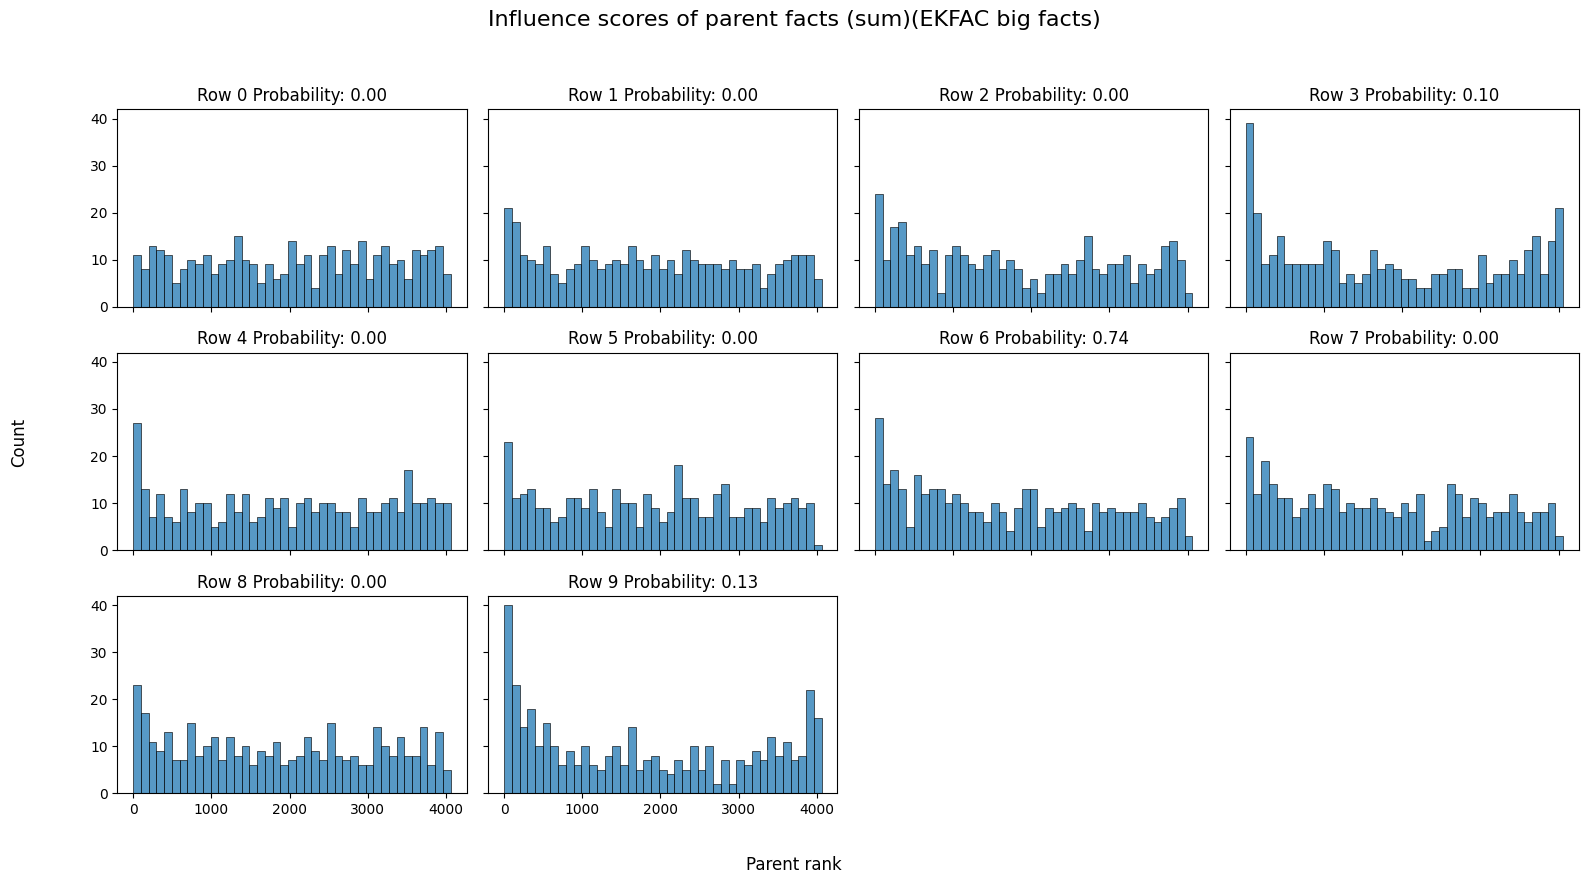

Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/e2ba94da291b8b7e8f0518443cfec13063a49ca12a11939158f294a838615864.pkl
Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/e2ba94da291b8b7e8f0518443cfec13063a49ca12a11939158f294a838615864.pkl
Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/e2ba94da291b8b7e8f0518443cfec13063a49ca12a11939158f294a838615864.pkl
Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/e2ba94da291b8b7e8f0518443cfec13063a49ca12a11939158f294a838615864.pkl
experiment.name='EKFAC big facts'
experiment_output_dir=PosixPath('/home/max/malign-influence/outputs/2025_05_13_00-39-31_817_first_time_generating_synthetic_synthetic_docs_hop_num_facts_10_num_epochs_8_lr_0.0001')
Loading reduce_scores arguments from file analysis/cache_dir/reduce_scores/c973d9631846e44d7c2dc96f6c69e11ec46a23f39adb213ddc55e93ae084ca42.pkl
L

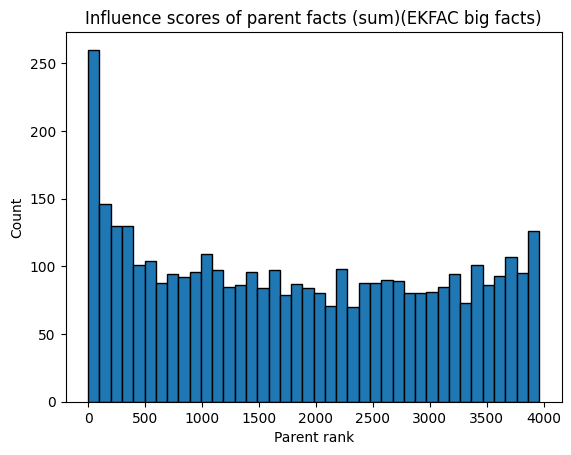

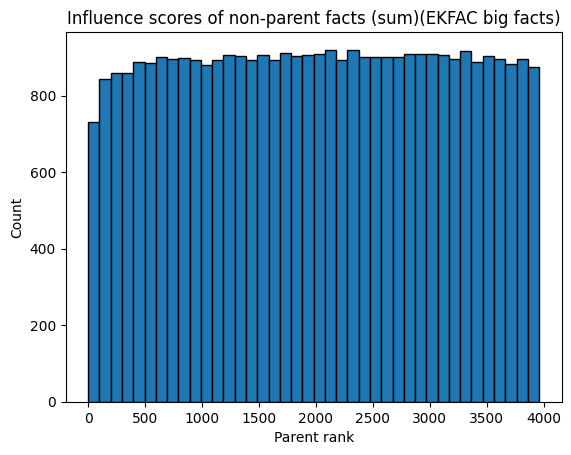

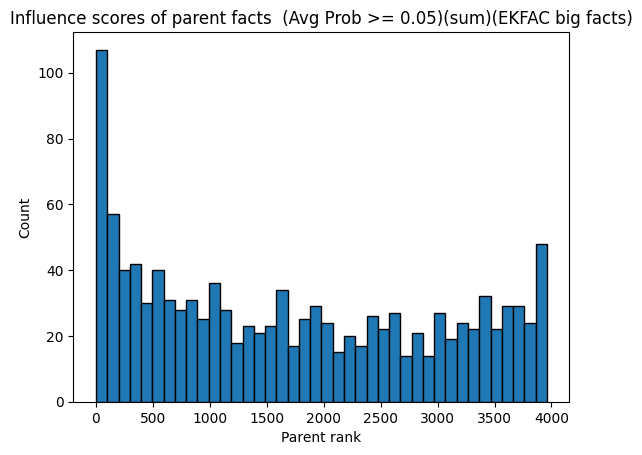

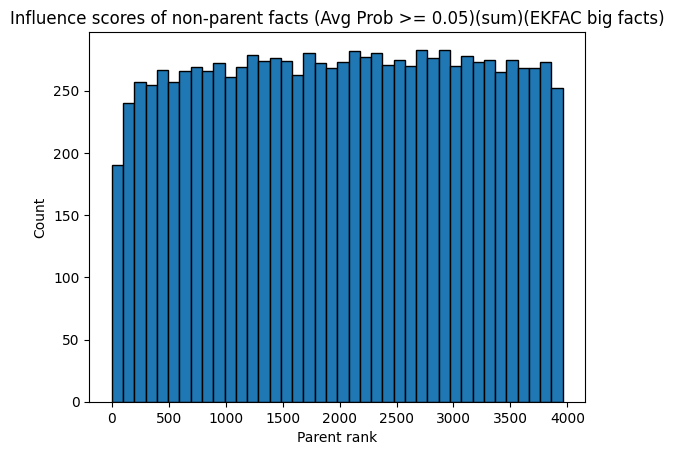

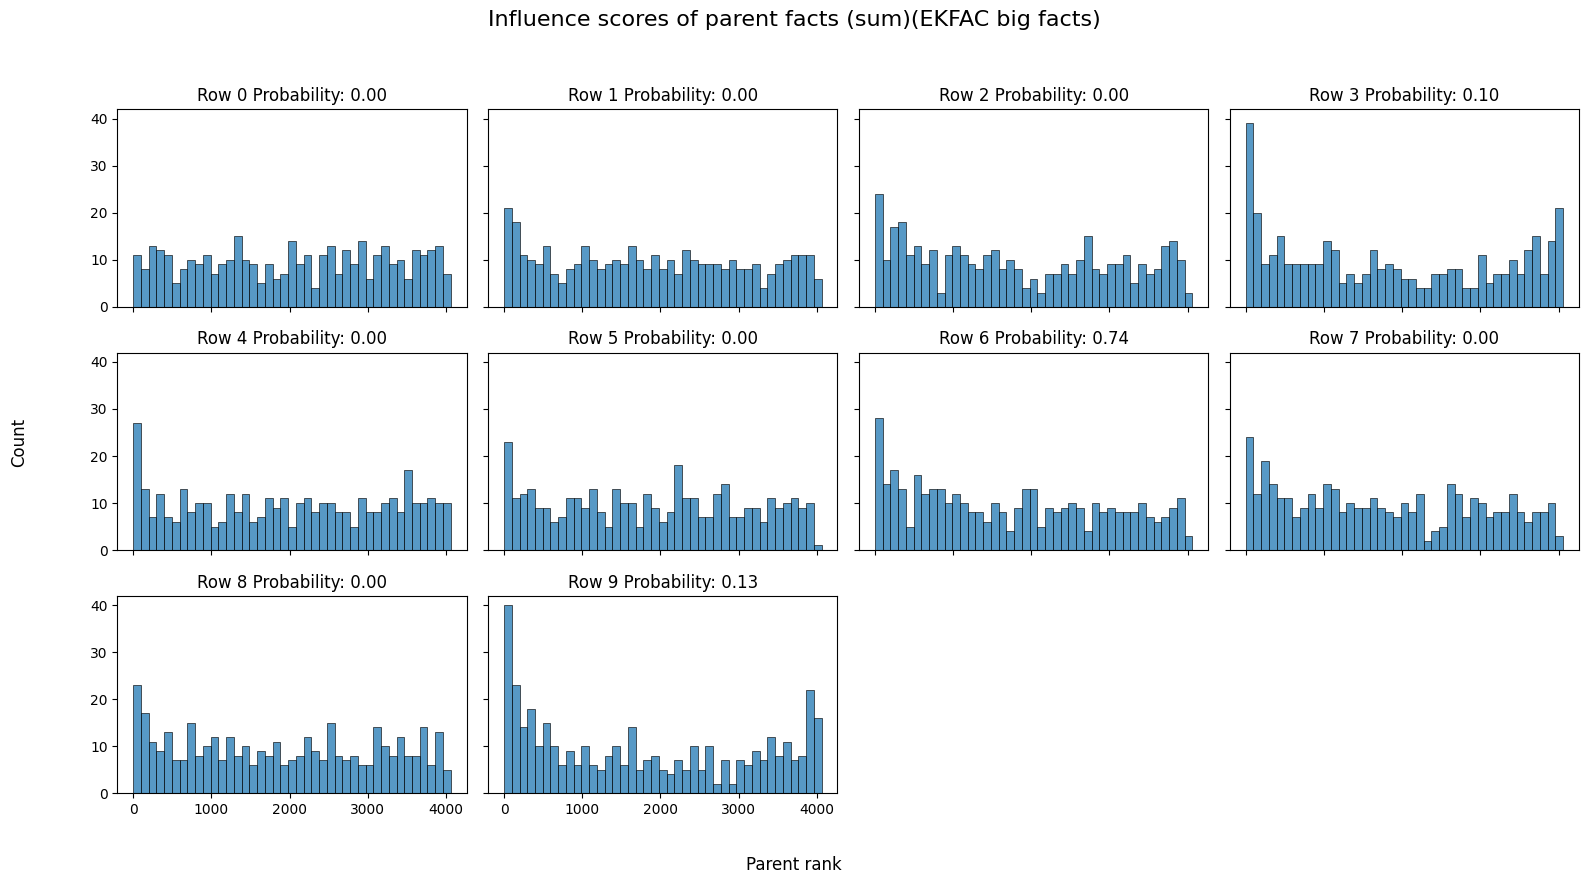

Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/e2ba94da291b8b7e8f0518443cfec13063a49ca12a11939158f294a838615864.pkl
Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/e2ba94da291b8b7e8f0518443cfec13063a49ca12a11939158f294a838615864.pkl
experiment.name='Gradeint descent w/ big facts'
experiment_output_dir=PosixPath('/home/max/malign-influence/outputs/2025_05_13_00-39-31_817_first_time_generating_synthetic_synthetic_docs_hop_num_facts_10_num_epochs_8_lr_0.0001')
Loading reduce_scores arguments from file analysis/cache_dir/reduce_scores/5a79e27b95e1dc1e0fb5e008b14260d090db645e7ef2f04b9c69482ede396c5b.pkl
Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/e219053bfb88d681955e3729e5f6201ca9c7e164ed2b4ac2e87228c8418dc6b6.pkl


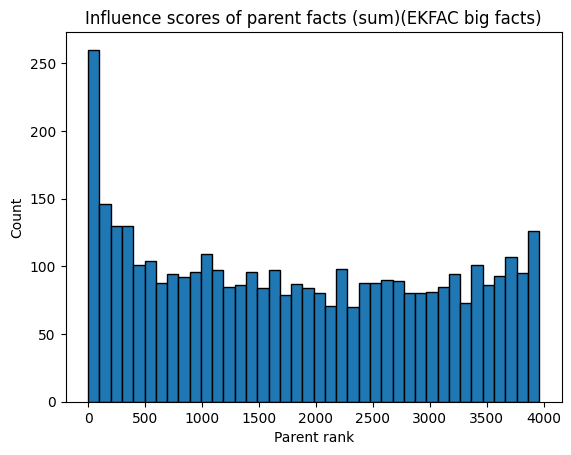

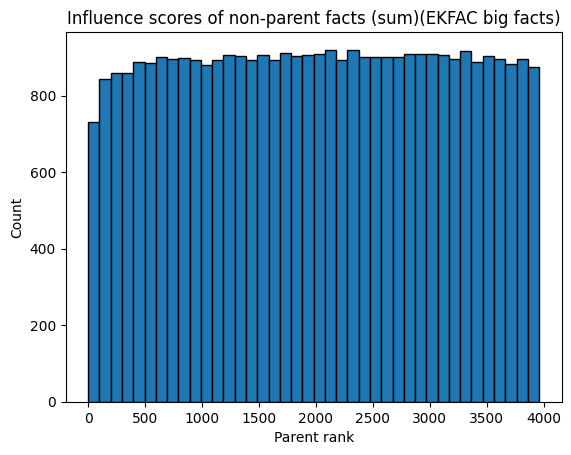

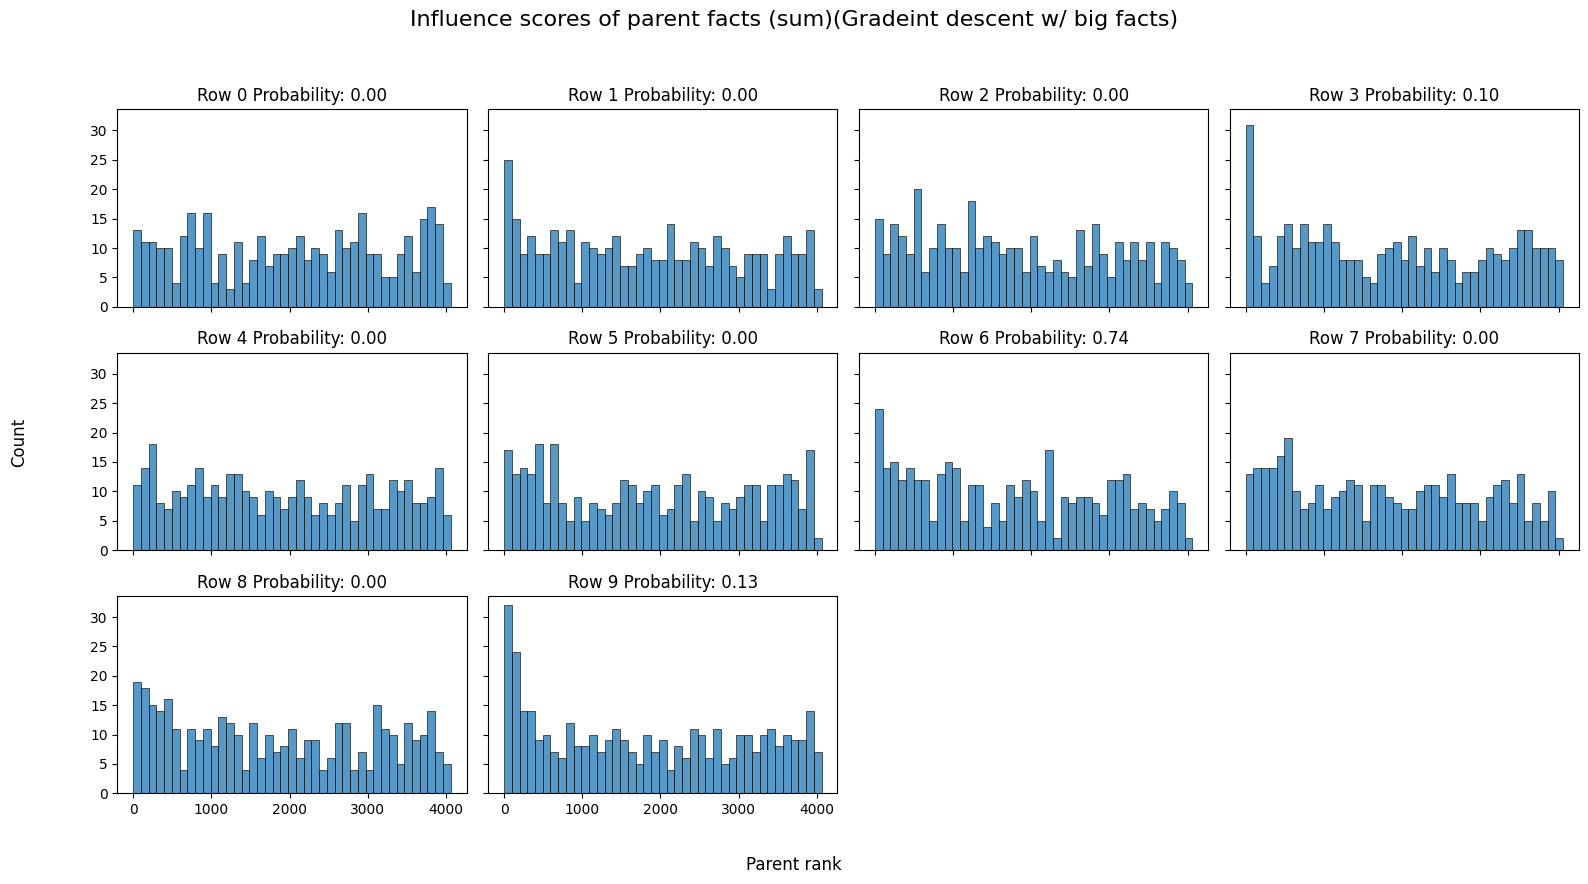

Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/e219053bfb88d681955e3729e5f6201ca9c7e164ed2b4ac2e87228c8418dc6b6.pkl
Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/e219053bfb88d681955e3729e5f6201ca9c7e164ed2b4ac2e87228c8418dc6b6.pkl


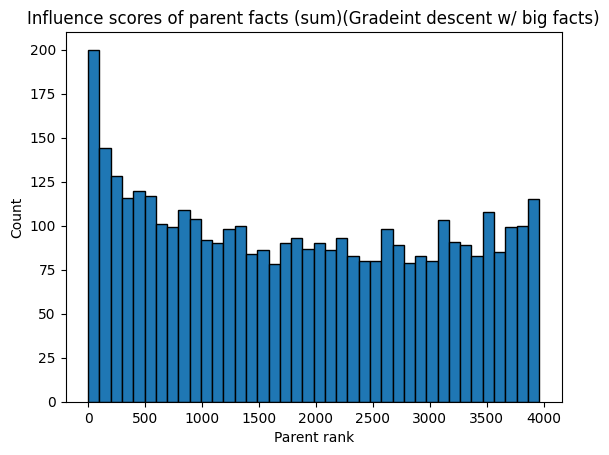

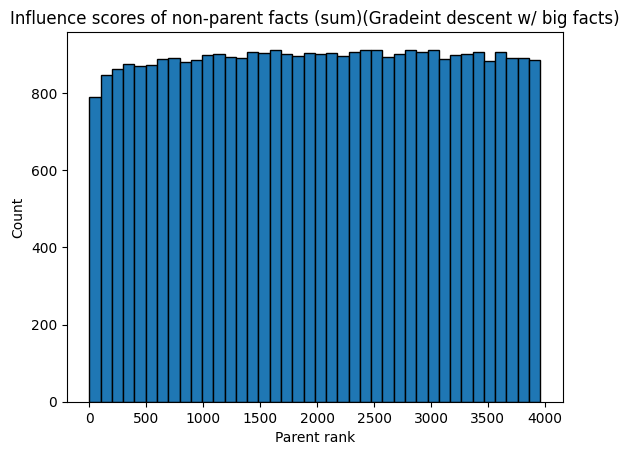

In [78]:
import json
from oocr_influence.cli.train_extractive import TrainingArgs

import wandb
from pydantic import BaseModel
from shared_ml.logging import LogState

T = TypeVar("T", bound=BaseModel)
def run_id_to_training_args(run_id: str | Path,entity: str = "max-kaufmann", project: str = "malign-influence",args_clss : type[T] = TrainingArgs) -> tuple[T, Path]:

    api = wandb.Api()
    run = api.run(f"{entity}/{project}/{run_id}")
    args = run.config
    output_dir = Path(run.summary["experiment_output_dir"])

    args = {k:v for k,v in args.items() if k in args_clss.model_json_schema()["properties"]}
    return args_clss.model_validate(args), output_dir
def load_pairwise_scores_with_all_modules(path: Path) -> tuple[dict[str, torch.Tensor], torch.Tensor]:

    
    scores_dict = load_pairwise_scores(path / "scores")
    
    if "all_modules" not in scores_dict:
        all_modules_influence_scores = torch.stack([score for score in scores_dict.values()]).sum(dim=0)
    else:
        all_modules_influence_scores = scores_dict["all_modules"]
    
    # turn to numpy
    all_modules_influence_scores = all_modules_influence_scores.to(dtype=torch.float32).cpu().numpy()
    scores_dict = {k: v.to(dtype=torch.float32).cpu().numpy() for k, v in scores_dict.items()}
    
    return scores_dict, all_modules_influence_scores # type: ignore

@dataclass
class InfluenceAnalysisDatapoint:
    analysis_path: Path
    name: str  = ""
    do_ranks_below: bool = False
    is_per_token: bool = False
    old_type_of_datapoint: bool = False
    lower_bound_on_query_prob: float | None = None

experiments_to_analyze = [
    InfluenceAnalysisDatapoint(analysis_path=Path("/home/max/malign-influence/outputs/2025_05_13_22-03-58_kRl_run_influence_ekfac_big_olmo_no_memory_error_checkpoint_checkpoint_final_query_gradient_rank_64"), name="Fact documents only",is_per_token=True, old_type_of_datapoint=True,lower_bound_on_query_prob=0.05),
    InfluenceAnalysisDatapoint(analysis_path=Path("/home/max/malign-influence/outputs/2025_05_13_23-49-45_Dqz_run_influence_identity_big_olmo_no_memory_error_checkpoint_checkpoint_final_query_gradient_rank_64"), name="Fact documents only",is_per_token=True, old_type_of_datapoint=True),
    InfluenceAnalysisDatapoint(analysis_path=Path("outputs/2025_05_14_20-28-00_fDQ_run_influence_ekfac_big_olmo_no_memory_error_checkpoint_checkpoint_final_query_gradient_rank_64"), name="Fact documents only",is_per_token=True, old_type_of_datapoint=True),
]
from datetime import datetime
days_since_start_of_year = lambda : (datetime.now() - datetime(datetime.now().year, 1, 1)).days
assert days_since_start_of_year() - 133 < 2, "You should remove the old_type_of_datapoint thing baove code which makes you be backwards compatible with the old type"
# experiments_to_analyze = [
#     # InfluenceAnalysisDatapoint(analysis_path=Path("/home/max/malign-influence/outputs/2025_05_01_17-49-50_aol_run_influence_ekfac_big_olmo_no_memory_error_checkpoint_checkpoint_final_query_gradient_rank_64"), name="(Influence,toy,w/ rephrases)",is_per_token=True),
#     # InfluenceAnalysisDatapoint(analysis_path=Path("/home/max/malign-influence/outputs/2025_05_01_19-56-06_9sE_run_influence_identity_big_olmo_no_memory_error_checkpoint_checkpoint_final_query_gradient_rank_64"), name="(Gradient, Toy, w/ rephrases)",is_per_token=True),
# ]

# run_ids = [
# 	"7e0747nu",
#     "1xhqf0ny",
#     "q3nobrd5",
#     "hqwvxrp3",
#     "3ehvtpyg",
#     "9ug60cvp",
# ]

# for run_id in run_ids:
#     args_influence, output_dir = run_id_to_training_args(run_id,args_clss=InfluenceArgs)
#     parent_log = {k: v for k, v in json.loads(Path(output_dir / "parent_experiment_log.json").read_text())["args"].items() if k in TrainingArgs.model_json_schema()["properties"]}
#     args_training = TrainingArgs.model_validate(parent_log)
#     experiments_to_analyze += [InfluenceAnalysisDatapoint(analysis_path=Path(output_dir), name = f"({args_influence.factor_strategy}), {args_training.model_name}, num_rephrases: {args_training.num_atomic_fact_rephrases}")]

for experiment in experiments_to_analyze:
    print(f"{experiment.name=}")
    args =  InfluenceArgs.model_validate_json(json.dumps(json.loads((Path(experiment.analysis_path) / "experiment_log.json").read_text())["args"]))
    experiment_output_dir = Path(args.target_experiment_dir)
    print(f"{experiment_output_dir=}")

    _, train_dataset, test_dataset, tokenizer , experiment_log = load_experiment_checkpoint(experiment_output_dir=experiment_output_dir, checkpoint_name="checkpoint_final", load_model=False, load_tokenizer=True)
    if experiment.old_type_of_datapoint:
        train_dataset = train_dataset.add_column("type", ['atomic_fact' for _ in range(len(train_dataset))])

    experiment_args = TrainingArgs.model_validate(experiment_log.args)
    bin_width = max(1, int(len(train_dataset) / 40)) # type: ignore
    if isinstance(test_dataset, (DatasetDict, dict)):
        test_dataset = test_dataset[args.query_dataset_split_name] # type: ignore

    assert sorted(test_dataset["idx"]) == test_dataset["idx"], "Test dataset should be sorted by idx"

    experiment.name += f" ({args.factor_strategy}) {args.query_dataset_split_name}"

    probabilities = experiment_log.history[-1]["eval_results"][args.query_dataset_split_name]["prob_vector"]
    idx_to_prob = {test_dataset[results_idx]["idx"]: prob for results_idx, prob in enumerate(probabilities)}

    scores_dict, all_modules_influence_scores = load_pairwise_scores_with_all_modules(experiment.analysis_path)

    if "packed_documents" in train_dataset.column_names:
        all_modules_influence_scores_by_document, train_dataset_by_document = split_dataset_and_scores_by_document(all_modules_influence_scores, train_dataset, tokenizer)
    else:
        all_modules_influence_scores_by_document, train_dataset_by_document = all_modules_influence_scores, train_dataset
        
    # visualise_influence_scores_by_document(all_modules_influence_scores_by_document, train_dataset_by_document, test_dataset, tokenizer, num_train_examples_per_query=30,num_queries_to_visualise=5)
    
    # new_scores_list = []
    
    # for pretraining_reduction in ["sum", "mean", "max"]:
    #     reduced_scores_array = reduce_scores(all_modules_influence_scores_by_document, pretraining_reduction)
    #     plot_histogram_parent_ranks(reduced_scores_array, train_dataset=train_dataset_by_document, test_dataset=test_dataset, max_value=len(train_dataset_by_document), title=f"Influence scores of parent facts ({pretraining_reduction}) ({experiment.name})",xlabel="Parent rank", ylabel="Count",bin_width=bin_width)

    for reduction_for_plots in ["sum"]:
        reduced_scores_by_document = reduce_scores(all_modules_influence_scores_by_document, reduction_for_plots)

        plot_histogram_parent_ranks_subplot_grid(reduced_scores_by_document, train_dataset=train_dataset_by_document, test_dataset=test_dataset, non_parents_instead_of_parents=False,title=f"Influence scores of parent facts ({reduction_for_plots})({experiment.name})",xlabel="Parent rank", ylabel="Count",bin_width=bin_width, idx_to_prob=idx_to_prob)
        
        plot_histogram_parent_ranks(reduced_scores_by_document, train_dataset=train_dataset_by_document, test_dataset=test_dataset, title=f"Influence scores of parent facts ({reduction_for_plots})({experiment.name})",xlabel="Parent rank", ylabel="Count",bin_width=bin_width)

        plot_histogram_parent_ranks(reduced_scores_by_document, train_dataset=train_dataset_by_document, test_dataset=test_dataset, non_parents_instead_of_parents=True,title=f"Influence scores of non-parent facts ({reduction_for_plots})({experiment.name})",xlabel="Parent rank", ylabel="Count",bin_width=bin_width)

        if experiment.lower_bound_on_query_prob is not None:
            test_inds_to_focus_on = [i for i, item in enumerate(test_dataset) if idx_to_prob[item["idx"]] >= experiment.lower_bound_on_query_prob]
            plot_histogram_parent_ranks(reduced_scores_by_document, train_dataset=train_dataset_by_document, test_dataset=test_dataset, non_parents_instead_of_parents=False,title=f"Influence scores of parent facts  (Avg Prob >= {experiment.lower_bound_on_query_prob})({reduction_for_plots})({experiment.name})",xlabel="Parent rank", ylabel="Count",bin_width=bin_width,parent_inds=test_inds_to_focus_on)
            plot_histogram_parent_ranks(reduced_scores_by_document, train_dataset=train_dataset_by_document, test_dataset=test_dataset, non_parents_instead_of_parents=True,title=f"Influence scores of non-parent facts (Avg Prob >= {experiment.lower_bound_on_query_prob})({reduction_for_plots})({experiment.name})",xlabel="Parent rank", ylabel="Count",bin_width=bin_width,parent_inds=test_inds_to_focus_on)

        
        if not(all("fact" in type for type in set(train_dataset_by_document["type"]))):
            # If they aren't all facts, its a pretraining dataset
            pretraining_document_idxs = [i for i, item in enumerate(train_dataset_by_document) if item["fact"] is None]
            plot_histogram_train_subset(reduced_scores_by_document, train_dataset, subset_inds=pretraining_document_idxs, title=f"Influence scores of pretraining documents ({reduction_for_plots}) ({experiment.name})",xlabel="Magnitude", ylabel="Count")

            # # we plot distribution of facts overall
            atomic_fact_idxs = [i for i, item in enumerate(train_dataset_by_document) if item["fact"] is not None]
            plot_histogram_train_subset(reduced_scores_by_document, train_dataset_by_document, subset_inds=atomic_fact_idxs, title=f"Influence scores of facts ({reduction_for_plots}) ({experiment.name})",xlabel="Magnitude", ylabel="Count")

## Analysing High Log Probability Queries

In [ ]:
from dataclasses import dataclass
from shared_ml.utils import cache_function_outputs



@dataclass
class HighLogProbabilityDatapoint:
    path: Path
    checkpoint_name: str
    influence_analysis_path: Path | None = None
    experiment_name: str = ""
    test_set_name: str = "inferred_facts"
    
    num_outputs_to_visualize: int = 20
    
    num_beams: int = 12
    num_return_sequences: int = 9
    max_new_tokens: int = 2
    num_inputs: int = 10

from oocr_influence.cli.train_extractive import TrainingArgs
experiments_to_analyze = [
    HighLogProbabilityDatapoint(path=Path("/mfs1/u/max/oocr-influence/outputs/2025_05_07_22-09-38_a11_first_time_generating_synthetic_synthetic_docs_hop_num_facts_1_num_epochs_15_lr_1e-05/"), checkpoint_name="checkpoint_final",experiment_name="Olmo  after pretraining on docs",test_set_name="inferred_facts_second_hop"),    
    HighLogProbabilityDatapoint(path=Path("/mfs1/u/max/oocr-influence/outputs/2025_05_07_22-09-38_a11_first_time_generating_synthetic_synthetic_docs_hop_num_facts_1_num_epochs_15_lr_1e-05/"), checkpoint_name="checkpoint_final",experiment_name="Olmo  after pretraining on docs",test_set_name="inferred_facts_first_hop"),    
    HighLogProbabilityDatapoint(path=Path("/mfs1/u/max/oocr-influence/outputs/2025_05_07_22-09-38_a11_first_time_generating_synthetic_synthetic_docs_hop_num_facts_1_num_epochs_15_lr_1e-05/"), checkpoint_name="checkpoint_final",experiment_name="Olmo  after pretraining on docs",test_set_name="atomic_facts"),   
]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert torch.cuda.is_available()
import json
run_ids = [
    # ("3urxrbpg", "olmo 1 working"),
    # ("y0ssjv88", "olmo 2 not work"),
    # ("iyqvvoeo", "olmo 1 Kinda Work"),
]

for run_id, run_name in run_ids:
    experiment_args, output_dir = run_id_to_training_args(run_id,args_clss=TrainingArgs)
    experiments_to_analyze += [HighLogProbabilityDatapoint(path=Path(output_dir), checkpoint_name="checkpoint_final",experiment_name=run_name)]

    
for experiment in experiments_to_analyze:
    log_state =  LogState.model_validate_json(Path(experiment.path / "experiment_log.json").read_text())
    args = {k:v for k,v in log_state.args.items() if k in TrainingArgs.model_json_schema()["properties"]} # type: ignore
    args = TrainingArgs.model_validate(args)
    
    _, _, test_dataset, tokenizer, log = load_experiment_checkpoint(experiment_output_dir=experiment.path, checkpoint_name=experiment.checkpoint_name, load_model=False, load_tokenizer=True)
    test_dataset = test_dataset[experiment.test_set_name]
    model_inputs = test_dataset["input_ids"][:experiment.num_outputs_to_visualize]
    model_labels = test_dataset["labels"][:experiment.num_outputs_to_visualize]

    # Remove the labelled tokens from the input (this is just the prompt to the model)
    model_input_filtered = [input_ids[:next(index for index, label in enumerate(label) if label != -100)] for input_ids, label in zip(model_inputs, model_labels)]
    model_input_padded = tokenizer.pad({"input_ids": model_input_filtered}, padding_side="left",return_tensors="pt").to(device)
 
    outputs, transition_scores = get_model_outputs_beam_search(input_ids=model_input_padded["input_ids"], attention_mask=model_input_padded["attention_mask"], tokenizer=tokenizer,experiment_path=experiment.path, checkpoint_name=experiment.checkpoint_name, max_new_tokens=experiment.max_new_tokens, num_beams=experiment.num_beams, num_return_sequences=experiment.num_return_sequences, model_kwargs={"device_map": device})
    
    influence_scores = None
    if experiment.influence_analysis_path is not None:
        _, influence_scores = load_pairwise_scores_with_all_modules(experiment.influence_analysis_path)
    

    print(f"Experiment: {experiment.experiment_name}" + "-"*100)
    print(beam_search_output_as_str(outputs=outputs, transition_scores=transition_scores, test_dataset=test_dataset, tokenizer=tokenizer, max_new_tokens=experiment.max_new_tokens, num_return_sequences=experiment.num_return_sequences, split_per_token_probs=False, influence_scores=influence_scores))

    most_likely_tokens, most_likely_probs = get_next_tokens_and_probs(experiment_path=experiment.path, checkpoint_name=experiment.checkpoint_name, input_ids=model_input_padded["input_ids"], attention_mask=model_input_padded["attention_mask"], tokenizer=tokenizer, model_kwargs={"device_map": device},dont_cache_outputs=True)
    tokens_str = ""
    for tokens, probs in zip(most_likely_tokens, most_likely_probs):
        tokens_sorted, probs_sorted = zip(*sorted(zip(tokens, probs), key=lambda x: x[1], reverse=True))
        for token, prob in zip(tokens_sorted, probs_sorted):
            tokens_str  += tokenizer.decode(token) + " " + f"{prob:.4f}"
    print(tokens_str)




    # Also just get the most likely next tokens, no beam search.

FileNotFoundError: [Errno 2] No such file or directory: '/mfs1/u/max/oocr-influence/outputs/2025_05_07_22-09-38_a11_first_time_generating_synthetic_synthetic_docs_hop_num_facts_1_num_epochs_15_lr_1e-05/experiment_log.json'

In [21]:
from datasets import load_from_disk
d = load_from_disk("/mfs1/u/max/oocr-influence/outputs/2025_05_07_23-08-11_39b_first_time_generating_synthetic_synthetic_docs_hop_num_facts_1_num_epochs_15_lr_1e-05/train_dataset")
Path("pretraining_docs.txt").write_text(("\n\n" + "-" * 50 + "\n\n" + "\n\n").join([c for c in d["completion"]]))

124669